In [1]:
import numpy as np
from control import *
import matplotlib.pyplot as plt
import sympy as sp
s=sp.Symbol('s')
from tqdm import tqdm
%matplotlib notebook
%matplotlib inline 

In [2]:
def eval_zeta(OS):
    return 1/(np.sqrt(1+((np.pi)/np.log(OS))**2))
 
def eval_wn(Ts,OS):
    return 4/(eval_zeta(OS)*Ts)
 
def eval_poles(wn,zeta):
    return -zeta*wn+wn*(np.sqrt(1-zeta**2))*1j

def eval_PM(zeta):
    return np.arctan((2*zeta)/np.sqrt(np.sqrt(4*zeta**4+1)-2*zeta**2))*180/np.pi

def eval_w_gc(zeta,wn):
    return wn*np.sqrt(np.sqrt(4*zeta**4+1)-2*zeta**2)

def get_settling_time(y,t):
    rev=y[::-1]
    for i in range(len(rev)):
        if np.abs(rev[i]-1)>0.02:
            print('Settling Time is %f'%t[len(y)-i])
            break
def get_OS(y):
    max_val=np.max(y)
    OS=(max_val-1)*100
    print('Percentage Overshoot is %f '%OS)

### Question 8

In [3]:
sp.expand(s*(0.1*s+1)*(s+1))

0.1*s**3 + 1.1*s**2 + s

Gain Margin:  8.78665387661
Phase Margin:  17.7050408744
Phase Crossover Frequency:  3.16227766017
Gain Crossover Frequency:  1.86121634596


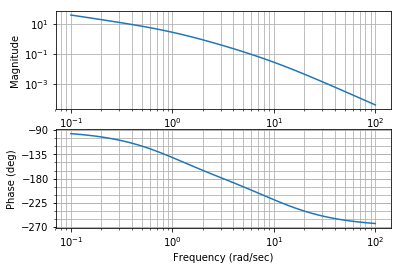

In [4]:
G=tf([4],[0.1,1.1,1,0])
m,p,w=bode(G)
GM,PM,wpc,wgc=margin(G)
GM=20*np.log10(GM) # as margin gives only magnitude and not in dB
print('Gain Margin: ',GM)
print('Phase Margin: ',PM)
print('Phase Crossover Frequency: ',wpc)
print('Gain Crossover Frequency: ',wgc)

In [5]:
desired_PM=45
phi_m=desired_PM-PM+15
alpha=(1-np.sin(phi_m*np.pi/180))/(1+np.sin(phi_m*np.pi/180))
mag=20*np.log10(1/np.sqrt(alpha))
loc=np.where(m<=10**(-mag/20))[0][0]
wm=w[loc]
T=1/(np.sqrt(alpha)*wm)
den=[float(i) for i in sp.Poly(sp.expand(s*(0.1*s+1)*(s+1)*(1+(alpha*T)*s))).coeffs()]
den.append(0)
num=[float(i) for i in sp.Poly(sp.expand(4*(1+s*T))).coeffs()]
Gc=tf(num,den)

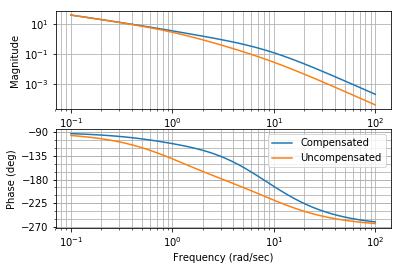

Gain Margin:  13.9826379276
Phase Margin:  45.9994413842
Phase Crossover Frequency:  7.85540347906
Gain Crossover Frequency:  2.82394229343


In [6]:
bode(Gc,label='Compensated')
bode(G,label='Uncompensated')
plt.legend()
plt.show()
GM,PM,wpc,wgc=margin(Gc)
GM=20*np.log10(GM) # as margin gives only magnitude and not in dB
print('Gain Margin: ',GM)
print('Phase Margin: ',PM)
print('Phase Crossover Frequency: ',wpc)
print('Gain Crossover Frequency: ',wgc)

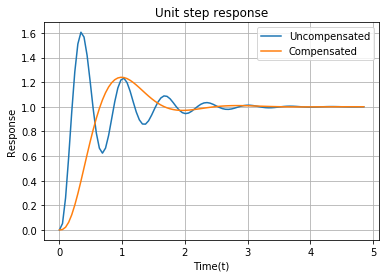

Settling Time is 2.205857
Percentage Overshoot is 23.972688 


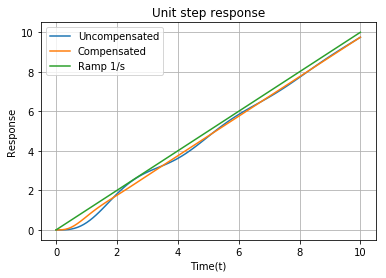

Steady State error: 0.250000063217
Kv: 3.99999898853


In [7]:
T=feedback(G,1)
To=feedback(Gc,1)
t=np.linspace(0,10,100)
ramp=tf([1,0],[1])
t,y=step_response(T)
t,y1=step_response(To)
plt.plot(t,y,label='Uncompensated')
plt.plot(t,y1,label='Compensated')
plt.grid()
plt.xlabel('Time(t)')
plt.ylabel('Response')
plt.title('Unit step response')
plt.legend()
plt.show()

get_settling_time(y1,t)
get_OS(y1)
# for ramp

t=np.linspace(0,10,100)
step=tf([1,0],[1])
t,y=step_response(T/step,t)
t,y1=step_response(To/step,t)
t,y2=step_response(1/step,t)
plt.plot(t,y,label='Uncompensated')
plt.plot(t,y1,label='Compensated')
plt.plot(t,y2,label='Ramp 1/s')
plt.grid()
plt.xlabel('Time(t)')
plt.ylabel('Response')
plt.title('Unit step response')
plt.legend()
plt.show()

print('Steady State error:',np.abs(y1[-1]-y2[-1]))
print('Kv:',1/np.abs(y1[-1]-y2[-1]))

# Question 10

In [8]:
k=1000*9*18/110
den=[float(i) for i in sp.Poly(sp.expand(s*(s+3)*(s+6)*(s+9))).coeffs()]
den.append(0)
num=[k*float(i) for i in sp.Poly(sp.expand((s+10)*(s+11))).coeffs()]
G=tf(num,den)

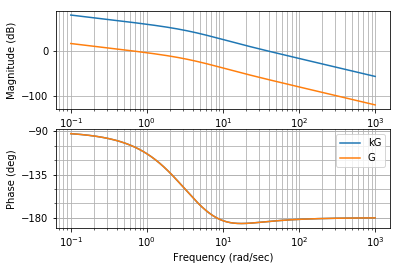

Gain Margin:  -29.3904918146
Phase Margin:  -3.99734470515
Phase Crossover Frequency:  8.20264304811
Gain Crossover Frequency:  38.9482530177


In [9]:
m,p,w=bode(G,omega_num=1e5,dB=True,label='kG')
bode(G/k,omega_num=1e5,dB=True,label='G')
plt.legend()
plt.show()
GM,PM,wpc,wgc=margin(G)
GM=20*np.log10(GM) # as margin gives only magnitude and not in dB
print('Gain Margin: ',GM)
print('Phase Margin: ',PM)
print('Phase Crossover Frequency: ',wpc)
print('Gain Crossover Frequency: ',wgc)

In [10]:
OS=0.15 #desired % overshoot
zeta=eval_zeta(OS)
desired_PM=eval_PM(eval_zeta(OS))
print(f'Desired Phase Margin:{desired_PM}')
angle=(-180+desired_PM+10)*np.pi/180


Desired Phase Margin:53.17183381591314


Alpha: 0.1954948220434724
omega_gc: 2.9470517025518097
phi_m:42.294959125557
magnitude(20log(1/sqrt(alpha))):791.0750069350659
Compensator 
8.607 s + 1
-----------
6808 s + 1



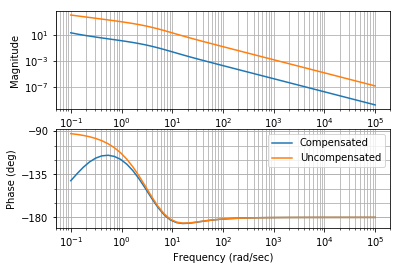

Gain Margin:  27.7338640319
Phase Margin:  57.3851242774
Phase Crossover Frequency:  7.85377747572
Gain Crossover Frequency:  1.16686024728


In [11]:
index=np.where(p<=angle)[0][0]
wgc=w[index]
mag=(m[index])
beta=mag
T=10/wgc
Gt=tf([T,1],[beta*T,1])
Gc=Gt*G
print(f'Alpha: {alpha}')
print(f'omega_gc: {wm}')
print(f'phi_m:{phi_m}')
print(f'magnitude(20log(1/sqrt(alpha))):{mag}')
print(f'Compensator {Gt}')

bode(Gc,label='Compensated',omega_limits=(1e-1,1e5))
bode(G,label='Uncompensated',omega_limits=(1e-1,1e5))
plt.legend()
plt.show()
GM1,PM1,wpc1,wgc1=margin(Gc)
GM1=20*np.log10(GM1) # as margin gives only magnitude and not in dB
print('Gain Margin: ',GM1)
print('Phase Margin: ',PM1)
print('Phase Crossover Frequency: ',wpc1)
print('Gain Crossover Frequency: ',wgc1)

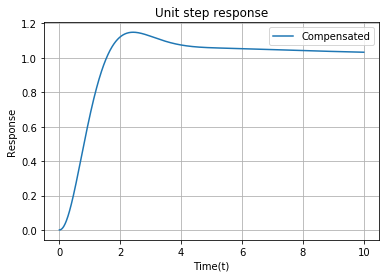

Percentage Overshoot is 14.885291 


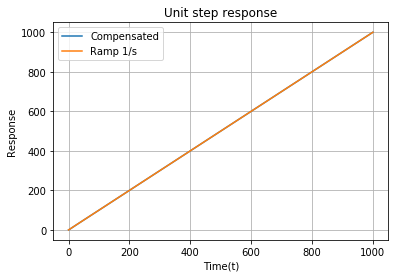

Kv: -999.998452521


In [12]:
T=feedback(G,1)
To=feedback(Gc,1)
t=np.linspace(0,10,1000)
ramp=tf([1,0],[1])
t,y=step_response(T,t)
t,y1=step_response(To,t)
#plt.plot(t,y,label='Uncompensated')
plt.plot(t,y1,label='Compensated')
plt.grid()
plt.xlabel('Time(t)')
plt.ylabel('Response')
plt.title('Unit step response')
plt.legend()
plt.show()

get_OS(y1)
# for ramp

t=np.linspace(0,1000,100000)
step=tf([1,0],[1])
t,y=step_response(T/step,t)
t,y1=step_response(To/step,t)
t,y2=step_response(1/step,t)
#plt.plot(t,y,label='Uncompensated')
plt.plot(t,y1,label='Compensated')
plt.plot(t,y2,label='Ramp 1/s')
plt.grid()
plt.xlabel('Time(t)')
plt.ylabel('Response')
plt.title('Unit step response')
plt.legend()
plt.show()

print('Kv:',1/(y1[-1]-y2[-1]))


In [13]:
# with lead compensator
'''
extra_phase=12
OS=0.15 #desired % overshoot
zeta=eval_zeta(OS)
desired_PM=eval_PM(eval_zeta(OS))
phi_m=desired_PM-PM+extra_phase
alpha=(1-np.sin(phi_m*np.pi/180))/(1+np.sin(phi_m*np.pi/180))
mag=20*np.log10(1/np.sqrt(alpha))
print('Desired zeta=%f'%zeta)
print('Desired Phase Margin=%f'%desired_PM)
print(f'Magnitude 20log(1/sqrt(alpha)): {mag}')
loc=np.where(20*np.log10(m)<-mag)[0][0]
wm=w[loc]
T=1/(np.sqrt(alpha)*wm)
#den=[float(i) for i in sp.Poly(sp.expand(s*(s+3)*(s+6)*(s+9)*(1+(alpha*T)*s))).coeffs()]
#den.append(0)
#num=[float(i) for i in sp.Poly(sp.expand(k*(s+10)*(s+11)*(1+T*s))).coeffs()]
Gt=tf([T,1],[alpha*T,1])
#Gc=tf(num,den)
Gc=Gt*G
print(f'Alpha: {alpha}')
print(f'omega_gc: {wm}')
print(f'phi_m:{phi_m}')
print(f'magnitude(20log(1/sqrt(alpha))):{mag}')
print(f'Compensator {Gt}')

bode(Gc,label='Compensated',omega_limits=(1e-1,1e5))
bode(G,label='Uncompensated',omega_limits=(1e-1,1e5))
plt.legend()
plt.show()
GM1,PM1,wpc1,wgc1=margin(Gc)
GM1=20*np.log10(GM1) # as margin gives only magnitude and not in dB
print('Gain Margin: ',GM1)
print('Phase Margin: ',PM1)
print('Phase Crossover Frequency: ',wpc1)
print('Gain Crossover Frequency: ',wgc1)
'''

"\nextra_phase=12\nOS=0.15 #desired % overshoot\nzeta=eval_zeta(OS)\ndesired_PM=eval_PM(eval_zeta(OS))\nphi_m=desired_PM-PM+extra_phase\nalpha=(1-np.sin(phi_m*np.pi/180))/(1+np.sin(phi_m*np.pi/180))\nmag=20*np.log10(1/np.sqrt(alpha))\nprint('Desired zeta=%f'%zeta)\nprint('Desired Phase Margin=%f'%desired_PM)\nprint(f'Magnitude 20log(1/sqrt(alpha)): {mag}')\nloc=np.where(20*np.log10(m)<-mag)[0][0]\nwm=w[loc]\nT=1/(np.sqrt(alpha)*wm)\n#den=[float(i) for i in sp.Poly(sp.expand(s*(s+3)*(s+6)*(s+9)*(1+(alpha*T)*s))).coeffs()]\n#den.append(0)\n#num=[float(i) for i in sp.Poly(sp.expand(k*(s+10)*(s+11)*(1+T*s))).coeffs()]\nGt=tf([T,1],[alpha*T,1])\n#Gc=tf(num,den)\nGc=Gt*G\nprint(f'Alpha: {alpha}')\nprint(f'omega_gc: {wm}')\nprint(f'phi_m:{phi_m}')\nprint(f'magnitude(20log(1/sqrt(alpha))):{mag}')\nprint(f'Compensator {Gt}')\n\nbode(Gc,label='Compensated',omega_limits=(1e-1,1e5))\nbode(G,label='Uncompensated',omega_limits=(1e-1,1e5))\nplt.legend()\nplt.show()\nGM1,PM1,wpc1,wgc1=margin(Gc)\nGM1=

### Question 12

In [14]:
OS=0.16
Ts=2/1000
zeta=eval_zeta(OS)
wn=eval_wn(Ts,OS)
desired_PM=eval_PM(zeta)
desired_w_gc=eval_w_gc(zeta,wn)
print(f'Desired Phase Margin:{desired_PM}')
print(f'Desired gain crossover frequency:{desired_w_gc}')

Desired Phase Margin:52.137944485003494
Desired gain crossover frequency:3109.6628215357177


Gain Margin:  inf
Phase Margin:  0.0
Phase Crossover Frequency:  nan
Gain Crossover Frequency:  182.574185835
G(s):
1e+05
-----
3 s^2



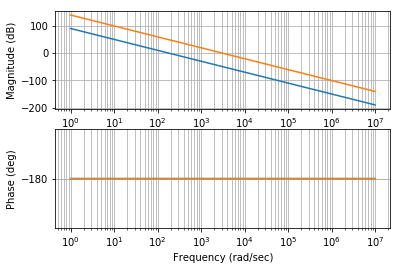

Gain Margin:  inf
Phase Margin:  0.0
Phase Crossover Frequency:  nan
Gain Crossover Frequency:  3109.66282154
G(s):
2.901e+07
---------
  3 s^2

Magnitude 20log(1/sqrt(alpha)) in dB: 16.073674468911257
Magnitude 0.15715068433487242


In [15]:
G=tf([1e5],[3,0,0])
m,p,w=bode(G,omega_limits=(1e0,1e7),dB=True,omega_num=1e5)
GM,PM,wpc,wgc=margin(G)
GM=20*np.log10(GM) # as margin gives only magnitude and not in dB
print('Gain Margin: ',GM)
print('Phase Margin: ',PM)
print('Phase Crossover Frequency: ',wpc)
print('Gain Crossover Frequency: ',wgc)
print(f'G(s):{G}')
k=3*desired_w_gc**2/1e5
G=k*G
m,p,w=bode(G,omega_limits=(1e0,1e7),dB=True,omega_num=1e5)
plt.show()
GM,PM,wpc,wgc=margin(G)
phi_m=desired_PM-PM+20
phi_m_rad=phi_m*np.pi/180  # convert to radians
alpha=(1-np.sin(phi_m_rad))/(1+np.sin(phi_m_rad))
GM=20*np.log10(GM) # as margin gives only magnitude and not in dB
print('Gain Margin: ',GM)
print('Phase Margin: ',PM)
print('Phase Crossover Frequency: ',wpc)
print('Gain Crossover Frequency: ',wgc)
print(f'G(s):{G}')
print(f'Magnitude 20log(1/sqrt(alpha)) in dB: {20*np.log10(1/np.sqrt(alpha))}')
print(f'Magnitude {np.sqrt(alpha)}')

In [16]:
index=np.where(-20*np.log10(1/np.sqrt(alpha))>=20*np.log10(m))[0][0]
w1=w[index]
print('Frequency where gain is to be added:',w1)

Frequency where gain is to be added: 7844.38581337


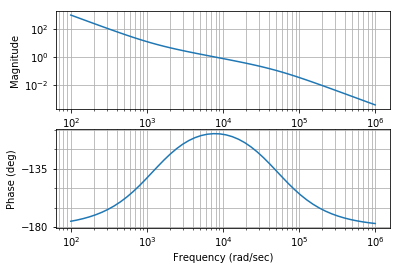

Gain Margin:  inf
Phase Margin:  72.1379444827
Phase Crossover Frequency:  nan
Gain Crossover Frequency:  7844.25545553
Gc: 
0.0008112 s + 1
---------------
2.003e-05 s + 1



In [17]:
phi_m=desired_PM-PM+20
phi_m_rad=phi_m*np.pi/180  # convert to radians
alpha=(1-np.sin(phi_m_rad))/(1+np.sin(phi_m_rad))
T=1/(np.sqrt(alpha)*w1)
Gt=tf([T,1],[alpha*T,1])
Gc=G*Gt
m,g,f=bode(Gc)
plt.show()
GM1,PM1,wpc1,wgc1=margin(Gc)
GM1=20*np.log10(GM1) # as margin gives only magnitude and not in dB
print('Gain Margin: ',GM1)
print('Phase Margin: ',PM1)
print('Phase Crossover Frequency: ',wpc1)
print('Gain Crossover Frequency: ',wgc1)
print('Gc:',Gt)

In [18]:
alpha

0.024696337586918714

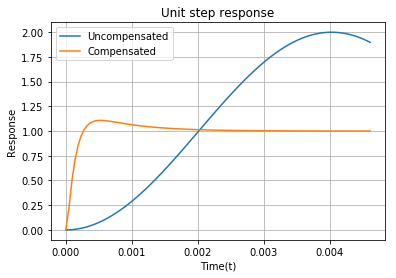

In [19]:
T=feedback(G,1)
To=feedback(Gc,1)
t=np.linspace(0,10,100)
ramp=tf([1,0],[1])
t,y=step_response(T)
t,y1=step_response(To)
plt.plot(t,y,label='Uncompensated')
plt.plot(t,y1,label='Compensated')
plt.grid()
plt.xlabel('Time(t)')
plt.ylabel('Response')
plt.title('Unit step response')
plt.legend()
plt.show()



In [20]:
get_settling_time(y1,t)
get_OS(y1)


Settling Time is 0.001817
Percentage Overshoot is 10.800067 


### Question 11

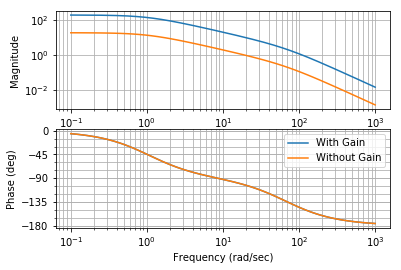

Gain Margin:  inf
Phase Margin:  32.2248751978
Phase Crossover Frequency:  nan
Gain Crossover Frequency:  110.108174323


In [21]:
k=10.46851
G=tf([k*1361],[1,69,70.85])
m,p,w=bode(G,label='With Gain',omega_num=1e4)
bode(G/k,label='Without Gain')
plt.legend()
plt.show()
GM,PM,wpc,wgc=margin(G)
GM=20*np.log10(GM) # as margin gives only magnitude and not in dB
print('Gain Margin: ',GM)
print('Phase Margin: ',PM)
print('Phase Crossover Frequency: ',wpc)
print('Gain Crossover Frequency: ',wgc)

In [22]:
GM,PM,wpc,wgc=margin(G/k)
GM=20*np.log10(GM) # as margin gives only magnitude and not in dB
print('Gain Margin: ',GM)
print('Phase Margin: ',PM)
print('Phase Crossover Frequency: ',wpc)
print('Gain Crossover Frequency: ',wgc)

Gain Margin:  inf
Phase Margin:  77.2924711127
Phase Crossover Frequency:  nan
Gain Crossover Frequency:  19.2414954407


In [23]:
index=np.where(w>=wgc)[0][0]
beta=m[index]
print(beta)
T=20/wgc

10.4584525066


In [24]:
T

1.0394202499325653

In [25]:
Gt=tf([T,1],[beta*T,1])
Gt


1.039 s + 1
-----------
10.87 s + 1

Alpha: 0.024696337586918714
omega_gc: 2.9470517025518097
phi_m:72.13794448500349
magnitude(20log(1/sqrt(alpha))):791.0750069350659
Compensator 
1.039 s + 1
-----------
10.87 s + 1



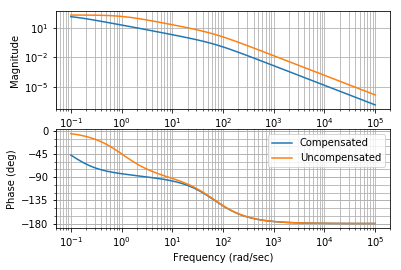

Gain Margin:  inf
Phase Margin:  74.6721693265
Phase Crossover Frequency:  nan
Gain Crossover Frequency:  19.2809218721


In [26]:
Gc=Gt*G
print(f'Alpha: {alpha}')
print(f'omega_gc: {wm}')
print(f'phi_m:{phi_m}')
print(f'magnitude(20log(1/sqrt(alpha))):{mag}')
print(f'Compensator {Gt}')

bode(Gc,label='Compensated',omega_limits=(1e-1,1e5))
bode(G,label='Uncompensated',omega_limits=(1e-1,1e5))
plt.legend()
plt.show()
GM1,PM1,wpc1,wgc1=margin(Gc)
GM1=20*np.log10(GM1) # as margin gives only magnitude and not in dB
print('Gain Margin: ',GM1)
print('Phase Margin: ',PM1)
print('Phase Crossover Frequency: ',wpc1)
print('Gain Crossover Frequency: ',wgc1)

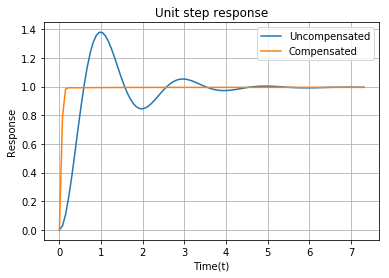

In [27]:
T=feedback(G,1)
To=feedback(Gc,1)
t=np.linspace(0,10,100)
ramp=tf([1,0],[1])
t,y=step_response(T)
t,y1=step_response(To)
plt.plot(t,y,label='Uncompensated')
plt.plot(t,y1,label='Compensated')
plt.grid()
plt.xlabel('Time(t)')
plt.ylabel('Response')
plt.title('Unit step response')
plt.legend()
plt.show()




### Question 13

In [54]:
tau=0.25
T=1.28
k=19
w=75.894


-195.80847984893055

In [138]:
w=0.8
quotient=((-2*w*T-np.arctan(w*tau)))//np.pi
remainder=((-2*w*T-np.arctan(w*tau)))%np.pi
print('Quotient:',quotient)
print('Remainder:',((-2*w*T-np.arctan(w*tau)))%np.pi)
PM=(-np.pi+remainder)*180/np.pi+180
print(PM)

Quotient: -1.0
Remainder: 0.89619709374
51.3483110832


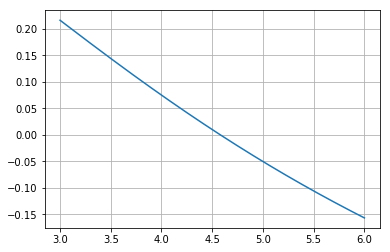

array([ 179.23184892,  179.18597353,  179.14009828,  179.09422318,
        179.04834821])

In [150]:
x=np.linspace(3,6,10000)
y=19*(np.sqrt(1+(18.631*x)**2))/(np.sqrt(1+(0.25*x)**2)*np.sqrt(1+(232.88*x)**2))-1
plt.plot(x,y)
plt.grid()
plt.show()
index=np.where(np.abs(y)<1e-4)[0]
w=x[index]
((-2*w*T-np.arctan(w*tau)+np.arctan(0.133*w)-np.arctan(0.13438*w))%np.pi)*180/np.pi

In [144]:
np.where(np.abs(y)<1e-5)[0]

array([], dtype=int64)

In [151]:
w=x[index]
((-2*w*T-np.arctan(w*tau)+np.arctan(0.133*w)-np.arctan(0.13438*w))%np.pi)*180/np.pi

array([ 179.23184892,  179.18597353,  179.14009828,  179.09422318,
        179.04834821])